<a href="https://colab.research.google.com/github/dangji1980/AI-Seminar-For-Shutoko-Eng/blob/main/AI%E5%85%A5%E9%96%80%E8%AC%9B%E5%BA%A7%E3%82%B5%E3%83%B3%E3%83%95%E3%82%9A%E3%83%AB%E3%82%B3%E3%83%BC%E3%83%88%E3%82%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIプログラムを構築してみよう
土木学会学会誌２０２１年1月号
サンプルコードと解説

テーマ：
「さあ，ＡＩを始めよう」
～土木工学へのAI導入のススメ～
AI入門講座（2）
～AIプログラムを構築してみよう～

コード作成者：埼玉大学　党紀、浅本晋吾



# （０）説明
AIプログラムを構築する一例として，畳み込みニューラルネットワーク(以下CNNと呼ぶ）を用いた画像分類問題を説明します。

使用モデル:CNN, ResNet

学習用データ:腐食とひび割れ分類

本コードと解説は，以下の3つで構成しています：（１）準備，（２）訓練，（３）テスト



#（１）準備
始める前に，まず以下の手順から環境設定を行ってください．

1. ページ上部の「ファイル」メニューから「PlayGroundモードで開く」を選択してください．

2. ページ上部の「ランタイム」メニューから「ランタイムのタイプを変更」を選択し、ハードウェアアクセラレーターをGPUと選択して「保存」を押してください。

3. 以下のコードセル（プログラムコードが記載されている部分）を順に実行してください。実行は、セル左端の実行ボタン（▷のマーク）をクリックすることで行うことができます。



In [ ]:
from google_drive_downloader import GoogleDriveDownloader
# Pics.zip: Corrosion and Crack detection
#https://drive.google.com/file/d/1m6SPFcX01OKAENjltBOfDY9sGm3RhjSV/view?usp=sharing
# data.zip: Corrosion Ranking Data: A,B,C
#https://drive.google.com/file/d/1JqtYRBbJGw0EniZJgAtTCwIhm6fKpT3k/view?usp=sharing
GoogleDriveDownloader.download_file_from_google_drive(file_id='1JqtYRBbJGw0EniZJgAtTCwIhm6fKpT3k',
                                                      dest_path="./data.zip",
                                                      unzip=True)
!rm data.zip        
!ls

Unzipping...Done.
data  __MACOSX	sample_data


In [ ]:
# ライブラリ導入
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Conv2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import plot_model
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import time
import os

In [ ]:
## フォルダの設定です。そのまま実行してください。
!ls
foldername="data"
#Pics , data

data  __MACOSX	sample_data


データの情報を確認します。構造物の腐食を分類する問題として，ここでは「A」,「B」,「C」という３ランクの写真をそれぞれ同名のフォルダに格納しています。
そのまま以下のセルを実行してください。



In [ ]:
def listdir_nohidden(path): #macでは.ds_dataなど見えないフォルダが存在するので、ここで除去
    filelist=[]
    for f in os.listdir(path):
        if not f.startswith('.'):   
            filelist.append(f)
    return filelist

folder = listdir_nohidden(foldername)
folder=sorted(folder)
name_classes=folder
num_classes=len(folder)
image_size = 224
dense_size  = len(name_classes)
print(folder)
#['A', 'B', 'C'] が下に現れたら、フォルダは正しく認識されている。

['A', 'B', 'C']


##データの導入とデータの可視化
データを読み込み，それぞれ訓練用とテスト用に分けます。

このプロセスは少し時間がかかる場合がありますが，実行が終わるまでお待ちください。実行が終わると，いくつかの画像例が表示されます。

loading: ./data/A
loading: ./data/B
loading: ./data/C


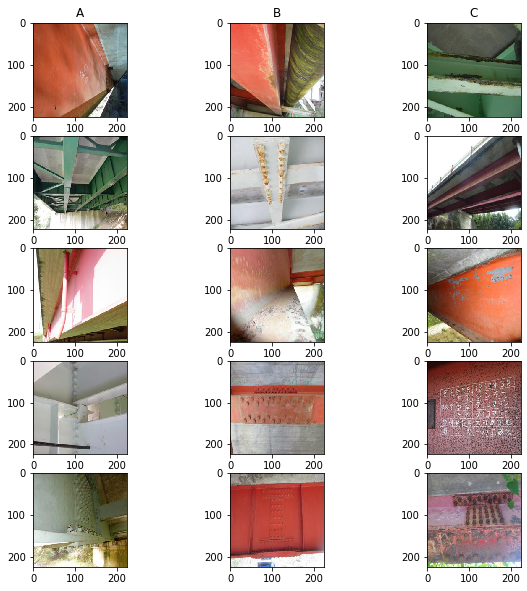

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # 図面のサイズを指定
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
X = []#入力データのリスト
Y = []#出力ラベルのリスト
samples_per_class=5
for index, classname in enumerate(folder): #enumerate番号と配列を同時取得
    dir = "./"+foldername+"/" + classname
    print("loading:",dir)
    files = glob.glob(dir + "/*.jpg")
    pickedfiles = np.random.choice(files, samples_per_class, replace=False)
    pickedfiles=sorted(pickedfiles)
    #print(classname,pickedfiles)
    iclass=0

    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)
        if file in pickedfiles:
            plt_idx = iclass * num_classes + index + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            if iclass == 0:
                plt.title(classname)
            plt.imshow(data)
            iclass+=1
    

X = np.array(X)
Y = np.array(Y)
X = X.astype('float32')
X = X / 255.0

Y = np_utils.to_categorical(Y, dense_size)#kerasの小道具箱np_utilsを活用
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10) #sklearnを活用

# （２）訓練
これで「（１）準備」は完了し，次に「（２）訓練」にうつります。

まずモデルを構築します。本デモでは，kerasと呼ばれるライブラリを使います。Kerasに実装されているCNNモデルを直接用いることもでき，vgg16であれば次のように一行で済ませることも出来ます。

model=keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

ここでは，CNNのモデルの構造を理解するために0から構築していきます。

なお，kerasのウェブサイトには様々な解説があるため，興味があればそちらを御参照下さい。

https://keras.io/ja/applications/


## Resnet50を使ってみる

###モデルの導入
ResNetと呼ばれるモデルをkerasから導入するコードを紹介します。
ResNetはkerasに封入されている標準モデルの一つであり、直接kerasから呼び出して使います。

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
model = ResNet50(weights='imagenet')


102973440/102967424 [==============================] - 1s 0us/step


###モデルの利用例
ここでは，学習させる写真を1つ，Resnetモデルに読み込む例を示します．

Unzipping...Done.


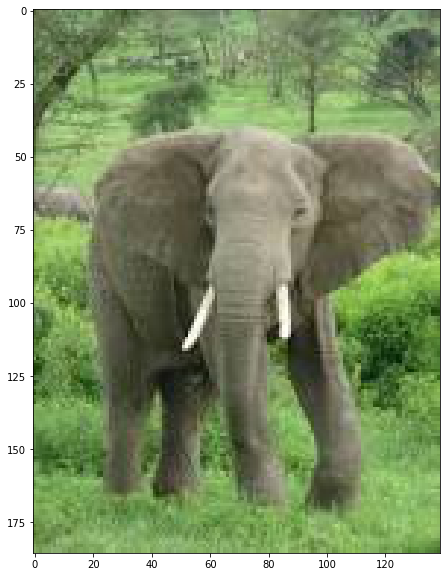

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.57901376), ('n01871265', 'tusker', 0.336514), ('n02504013', 'Indian_elephant', 0.08447219)]


In [ ]:
#何かの写真ダウンロードしておく
imgname= 'elephant.jpg'
#例えば，象の写真は，下記のリンクから直接ダウンロードすることもできる。
#https://drive.google.com/file/d/1Vb989Nq0sgi7RI7CUXiSzr1KIcbLZ7k7/view?usp=sharing
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='1Vb989Nq0sgi7RI7CUXiSzr1KIcbLZ7k7',
                                                      dest_path="./e.zip",
                                                      unzip=True)
!rm e.zip

def predict_one(img_path = 'elephant.jpg'):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print('Predicted:', decode_predictions(preds, top=3)[0])
    # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]
predict_one(img_path =imgname)


## 転移学習

次に，独自の問題に転移学習を実施したコードを紹介します。
深層学習では，基礎的な特徴量抽出の畳み込み層の学習に多くの訓練時間を費やしています。
転移学習では，標準に用意された大規模のデータベースを用いて，基礎的な部分をしっかり訓練されたベースモデルを土台とし，少量のデータでもさらに精度を高める方法（Fine-turning）を用います。これは訓練するデータが少ない時によく使われています。

### ベースモデルの導入

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# まずベースモデルをKerasのResNet50のライブラリーから取り出します。imagenetで訓練済みのものかつ最後の出力のヘッド部分をいらないように設定できます。
base_model = ResNet50(weights='imagenet', include_top=False)
# その上にプーリング層を新たに設置します。
x = base_model.output
x = GlobalAveragePooling2D()(x)
# 次に全結合層を加えます。
x = Dense(1024, activation='relu')(x)
# 最後に分類問題の予測のためにソフトマックスで出力を追加します。予測したい鋼材腐食のランクは３ランクであるため、出力サイズをクラス数３とします。。
predictions = Dense(num_classes, activation='softmax')(x)
# これを用いて訓練します。
model = Model(inputs=base_model.input, outputs=predictions)


94773248/94765736 [==============================] - 1s 0us/step


###転移学習の訓練
ここでは上記の設定で、Google ColabではGPUを用いて訓練が実施し、概ね１エポック３秒かかりますが、CPUで訓練するとかなり時間がかかります。

In [ ]:
# まず基礎モデルの入力画像に近い層の重みは変更しないようにします。
# すると，浅いヘッド層（NNの部分, DenseNet, 全結合層）だけ訓練されます。
for layer in base_model.layers:
    layer.trainable = False

# モデルの訓練方法など設定（コンパイル）
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
epochs = 100  # 300?
# モデルを少しだけ訓練します。本来では100から300くらいまでのエポックで訓練した方が望ましいと思われます。
history=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
model.save_weights('mymodel_weights.h5')

Epoch 1/100
20/20 [==============================] - 4s 206ms/step - loss: 2.1055 - accuracy: 0.3243 - val_loss: 1.6974 - val_accuracy: 0.4143
Epoch 2/100
20/20 [==============================] - 3s 133ms/step - loss: 1.3779 - accuracy: 0.3530 - val_loss: 1.1069 - val_accuracy: 0.3571
Epoch 3/100
20/20 [==============================] - 3s 133ms/step - loss: 1.2904 - accuracy: 0.3754 - val_loss: 1.1918 - val_accuracy: 0.3571
Epoch 4/100
20/20 [==============================] - 3s 132ms/step - loss: 1.3460 - accuracy: 0.3419 - val_loss: 1.7560 - val_accuracy: 0.2286
Epoch 5/100
20/20 [==============================] - 3s 133ms/step - loss: 1.1798 - accuracy: 0.3914 - val_loss: 1.1100 - val_accuracy: 0.3571
Epoch 6/100
20/20 [==============================] - 3s 134ms/step - loss: 1.2938 - accuracy: 0.3227 - val_loss: 1.3135 - val_accuracy: 0.4143
Epoch 7/100
20/20 [==============================] - 3s 133ms/step - loss: 1.1162 - accuracy: 0.3946 - val_loss: 1.2019 - val_accuracy: 0.3571

### 訓練結果の可視化
訓練及び検証データの誤差と精度をプロットします。

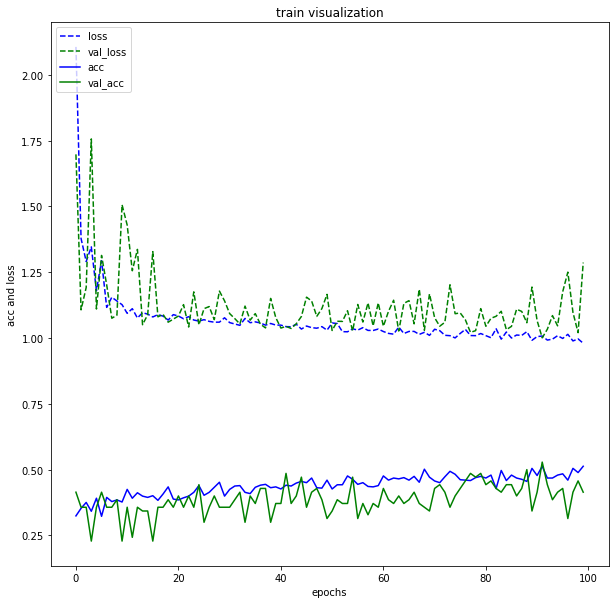

<Figure size 720x720 with 0 Axes>

In [ ]:
def visualizeHistory(history,name='train.png'):
    
    plt.plot(history.history['loss'],color='blue',label='loss',linestyle = "dashed")
    plt.plot(history.history['val_loss'],color='green',label='val_loss',linestyle = "dashed")
    plt.plot(history.history['accuracy'],color='blue',label='acc')
    plt.plot(history.history['val_accuracy'],color='green',label='val_acc')
    plt.title('train visualization')
    plt.ylabel('acc and loss')
    plt.xlabel('epochs')
    plt.legend( loc='upper left')
    plt.show()
    plt.savefig(name, bbox_inches='tight')
    return None
visualizeHistory(history,'transferlearning.png')

### 精度を高めるFine Tuning
ここでは，まずモデルの構成をリストでチェックします。


In [ ]:
for i,layer in enumerate(model.layers):
    print("layer:%d"%i,layer.name)

layer:0 input_2
layer:1 conv1_pad
layer:2 conv1_conv
layer:3 conv1_bn
layer:4 conv1_relu
layer:5 pool1_pad
layer:6 pool1_pool
layer:7 conv2_block1_1_conv
layer:8 conv2_block1_1_bn
layer:9 conv2_block1_1_relu
layer:10 conv2_block1_2_conv
layer:11 conv2_block1_2_bn
layer:12 conv2_block1_2_relu
layer:13 conv2_block1_0_conv
layer:14 conv2_block1_3_conv
layer:15 conv2_block1_0_bn
layer:16 conv2_block1_3_bn
layer:17 conv2_block1_add
layer:18 conv2_block1_out
layer:19 conv2_block2_1_conv
layer:20 conv2_block2_1_bn
layer:21 conv2_block2_1_relu
layer:22 conv2_block2_2_conv
layer:23 conv2_block2_2_bn
layer:24 conv2_block2_2_relu
layer:25 conv2_block2_3_conv
layer:26 conv2_block2_3_bn
layer:27 conv2_block2_add
layer:28 conv2_block2_out
layer:29 conv2_block3_1_conv
layer:30 conv2_block3_1_bn
layer:31 conv2_block3_1_relu
layer:32 conv2_block3_2_conv
layer:33 conv2_block3_2_bn
layer:34 conv2_block3_2_relu
layer:35 conv2_block3_3_conv
layer:36 conv2_block3_3_bn
layer:37 conv2_block3_add
layer:38 conv

層番号をチェックしていくとconv5まで切りが良さそうなので，143層まで開放します。

In [ ]:
num_free_layer=143
for layer in model.layers[:num_free_layer]:
   layer.trainable = False
for layer in model.layers[num_free_layer:]:
   layer.trainable = True


時間負荷軽減のため，epoch数は30と少な目に設定します。時間がありましたら，300エポックの訓練を試してください。



Epoch 1/30
20/20 [==============================] - 3s 135ms/step - loss: 1.0087 - accuracy: 0.4904 - val_loss: 1.2551 - val_accuracy: 0.3571
Epoch 2/30
20/20 [==============================] - 3s 133ms/step - loss: 1.0003 - accuracy: 0.4824 - val_loss: 1.0712 - val_accuracy: 0.4143
Epoch 3/30
20/20 [==============================] - 3s 133ms/step - loss: 0.9954 - accuracy: 0.4744 - val_loss: 1.0626 - val_accuracy: 0.4286
Epoch 4/30
20/20 [==============================] - 3s 134ms/step - loss: 1.0066 - accuracy: 0.4537 - val_loss: 1.0481 - val_accuracy: 0.4286
Epoch 5/30
20/20 [==============================] - 3s 132ms/step - loss: 0.9883 - accuracy: 0.4968 - val_loss: 1.0401 - val_accuracy: 0.4000
Epoch 6/30
20/20 [==============================] - 3s 133ms/step - loss: 1.0141 - accuracy: 0.4649 - val_loss: 0.9944 - val_accuracy: 0.5571
Epoch 7/30
20/20 [==============================] - 3s 133ms/step - loss: 0.9757 - accuracy: 0.5383 - val_loss: 1.1354 - val_accuracy: 0.3571
Epoch 

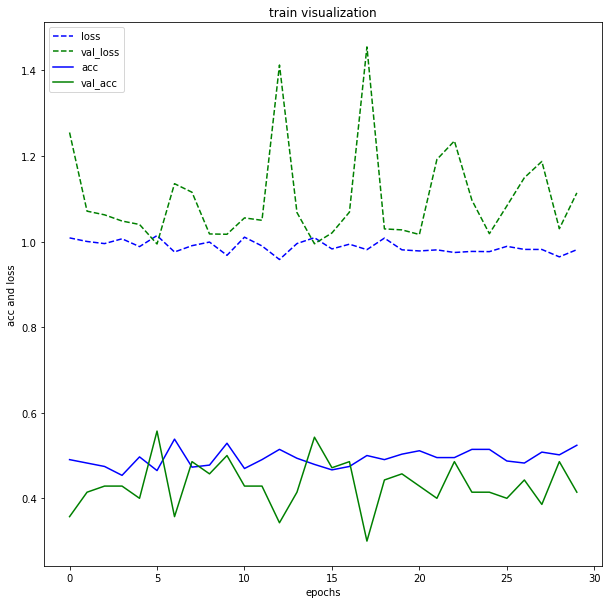

<Figure size 720x720 with 0 Axes>

In [ ]:
epochs = 30  # 300?
# 訓練の実施、返り値としては訓練の履歴
history=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)

model.save_weights('mymodel_weights_final.h5')
#結果の可視化
visualizeHistory(history)


### 転移学習とFine turningのコード統合
以上の移転学習とFine tuningによる訓練という２つのステップを一つのセルに統合すると，まとめて実行されます。実際に使う場合は，下記のセルだけを実行すればよいことになります。


In [ ]:

# まずベースモデルをKerasのResNet50のライブラリーから取り出します。imagenetで訓練済みのものかつ最後の出力のヘッド部分をいらないように設定できます。
base_model = ResNet50(weights='imagenet', include_top=False)
# その上にプーリング層を新たに設置します。
x = base_model.output
x = GlobalAveragePooling2D()(x)
# 次に全結合層を加えます。
x = Dense(1024, activation='relu')(x)
# 最後に分類問題の予測のためにソフトマックスで出力を追加します。予測したい鋼材腐食のランクは３ランクであるため、出力サイズをクラス数３とします。。
predictions = Dense(num_classes, activation='softmax')(x)
# これを用いて訓練します。
model = Model(inputs=base_model.input, outputs=predictions)

#ステージ 01　転移学習
# まず基礎モデルの入力画像に近い層の重みは変更しないようにします。
# すると，浅いヘッド層（NNの部分, DenseNet, 全結合層）だけ訓練されます。
for layer in base_model.layers:
    layer.trainable = False

# モデルの訓練方法など設定（コンパイル）
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
epochs = 100  # 300?
# モデルを少しだけ訓練します。本来では100から300くらいまでのエポックで訓練した方が望ましいと思われます。
history1=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
model.save_weights('mymodel_weights.h5')
#結果の可視化
visualizeHistory(history1,'transferlearning.png')

#ステージ 02 ファイチューニング(Fine-tuning)
num_free_layer=143
for layer in model.layers[:num_free_layer]:
   layer.trainable = False
for layer in model.layers[num_free_layer:]:
   layer.trainable = True

epochs = 100  # 300?
# 改めて訓練
history2=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
model.save_weights('mymodel_weights_final.h5')
#結果の可視化
visualizeHistory(history2,'finetuning.png')

In [ ]:
visualizeHistory(history2,'finetuing.png')

#（３）テスト
最後に，訓練モデルを使い，橋梁劣化のテストデータをテストしてみます。
予測の精度を以下のように，可視化します。


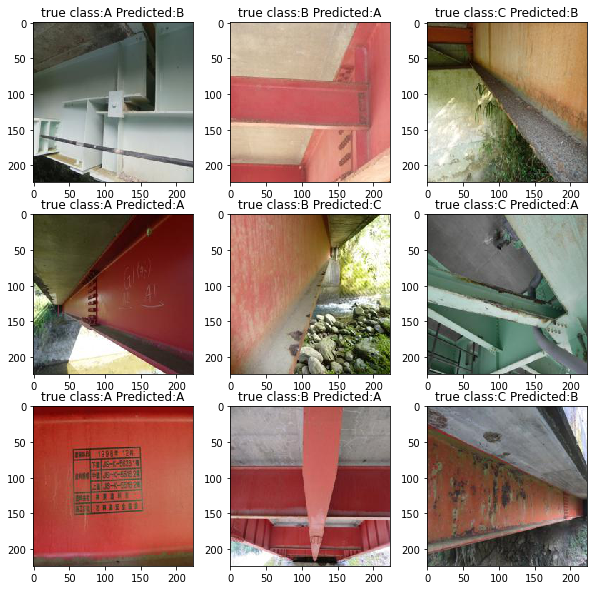

In [ ]:
def testvisualization(samples_per_class=3):
    for y, cls in enumerate(folder): #enumerate番号と配列を同時取得
        dir = "./"+foldername+"/" + cls
        files = glob.glob(dir + "/*.jpg")
        picedfiles = np.random.choice(files, samples_per_class, replace=False)
        for i, file in enumerate(picedfiles):
            img = image.load_img(file, target_size=(224, 224))
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(img)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            preds = model.predict(x)
            s="true class:"+cls+" Predicted:"+name_classes[preds[0].argmax()]        
            plt.title(s)
    plt.show()  
testvisualization(3)

# その他：CNNをゼロから組み上げたモデルの場合
上記はCNNについてResnetというモジュールを導入しましたが，CNNをゼロからくみ上げた場合のプログラミング方法を説明します。
まず，以下のようなコードでたたき込みのモデルを構築します。

## ゼロからモデルを組み上げ

In [ ]:
def CnnModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(dense_size))
    model.add(Activation('softmax'))

    model.summary()
    return model

### 自作モデルの可視化


このCNNモデルの中身は以下のようになります。

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      1

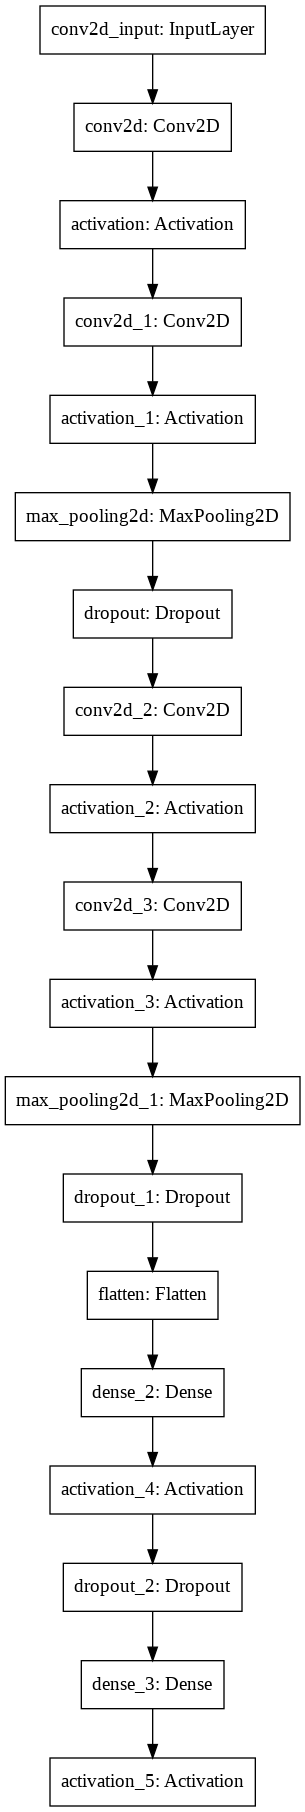

In [ ]:
model=CnnModel()
plot_model(model, to_file='model.png')

## 初期状態から学習
初期のパラメータはランダムで小さい値であり，まったく事前訓練を受けていない状態です。これから直接訓練し，パラメータを求めていくことになります。画像データ数が足りないため，過学習を起こしてしまいますが，デモのためにあえて実施してみます。

In [ ]:
#最適化手法として選択できます:SGD, Adagrad, Adam, Adamax, RMSprop, Nadam
optimizers=Adam(lr=0.0001)
epochs = 30     # たくさんのデータがあれば、いい精度を絞り出すために 100 or 200が良いかもしれません。
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])
history= model.fit(X_train, y_train, validation_split=0.1, epochs=epochs )#<-ここで訓練の実施
model_json_str = model.to_json()
open('mnist_mlp_model.json', 'w').write(model_json_str)
model.save_weights('mymodel_weights.h5')

Epoch 1/30
20/20 [==============================] - 4s 205ms/step - loss: 1.2514 - accuracy: 0.3387 - val_loss: 1.0917 - val_accuracy: 0.3714
Epoch 2/30
20/20 [==============================] - 3s 164ms/step - loss: 1.0774 - accuracy: 0.4201 - val_loss: 1.0886 - val_accuracy: 0.3714
Epoch 3/30
20/20 [==============================] - 3s 163ms/step - loss: 1.0738 - accuracy: 0.4393 - val_loss: 1.0708 - val_accuracy: 0.5571
Epoch 4/30
20/20 [==============================] - 3s 163ms/step - loss: 1.0470 - accuracy: 0.4585 - val_loss: 1.0257 - val_accuracy: 0.5429
Epoch 5/30
20/20 [==============================] - 3s 162ms/step - loss: 1.0136 - accuracy: 0.4808 - val_loss: 0.9877 - val_accuracy: 0.5857
Epoch 6/30
20/20 [==============================] - 3s 163ms/step - loss: 0.9975 - accuracy: 0.4888 - val_loss: 0.9496 - val_accuracy: 0.5714
Epoch 7/30
20/20 [==============================] - 3s 163ms/step - loss: 0.9487 - accuracy: 0.5240 - val_loss: 0.9285 - val_accuracy: 0.6429
Epoch 

### 訓練の履歴の可視化（過学習）

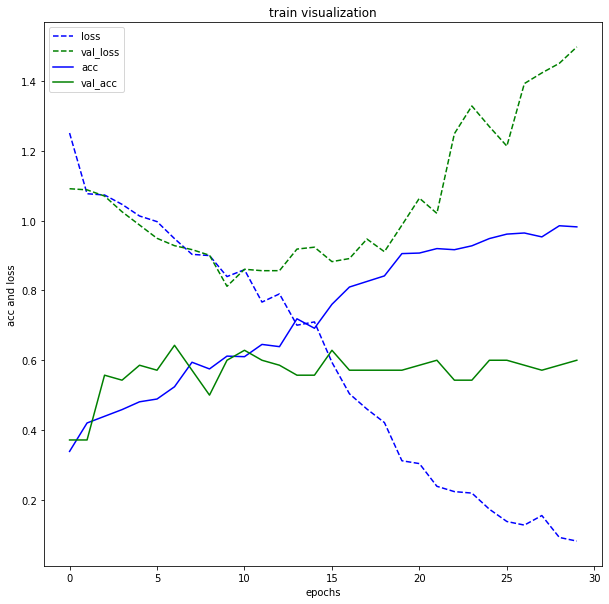

<Figure size 720x720 with 0 Axes>

In [ ]:
visualizeHistory(history)

以上のように過学習してしまい、精度は上がりませんでした。
## テストと精度検証
テストデータを用いて，モデルの精度を検証します。（1）準備のさい，訓練データと別にテストデータ(X_test,y_test)を用意しました。ここで，構築したモデルを使って，テストデータのXからyを予測してみます。以下のように1行のコードでテストし，誤差と精度を得ることができます。

In [ ]:
#reference:https://medium.com/@manasnarkar/image-classification-with-convolution-neural-networks-cnn-with-keras-dbd71c05ed2a
test_loss, test_acc = model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 100ms/step - loss: 1.2185 - accuracy: 0.6538



### 混同行列を描く
具体的に，どこの精度が良い，どこが問題であるかを分析するためには，以下のコードで作成された混同行列が有効です。

Confusion matrix, without normalization
[[14  2  3]
 [ 7  7  9]
 [ 3  3 30]]


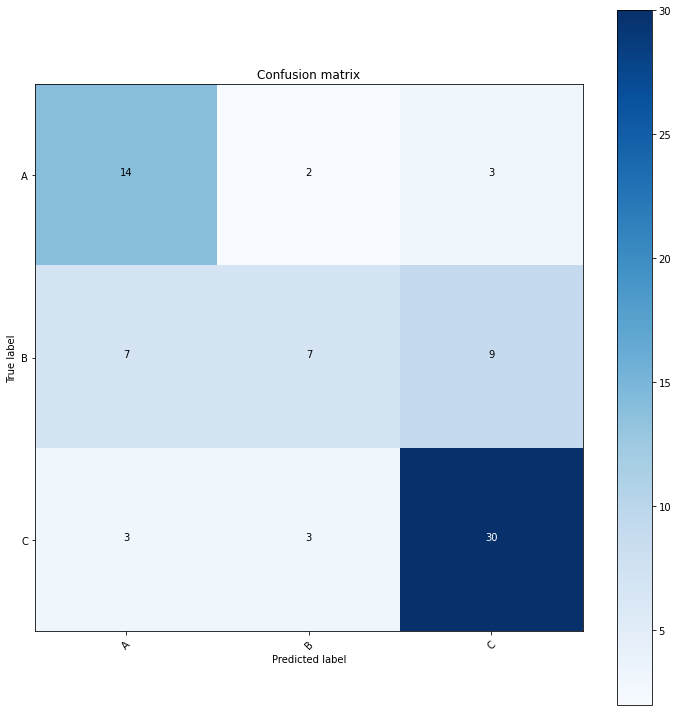

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confutionmatrix.jpg')


pred_y = model.predict(X_test)
pred_y_classes = np.argmax(pred_y,axis = 1) 
tue_y= np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(tue_y, pred_y_classes) 
plot_confusion_matrix(confusion_mtx, classes = folder) 

# reference:http://kinpatucom821.hatenablog.com/entry/2018/08/30/215419

### サンプルデータで可視化
最後に，前に定義した関数を使うことで，テスト結果の可視化が可能です。

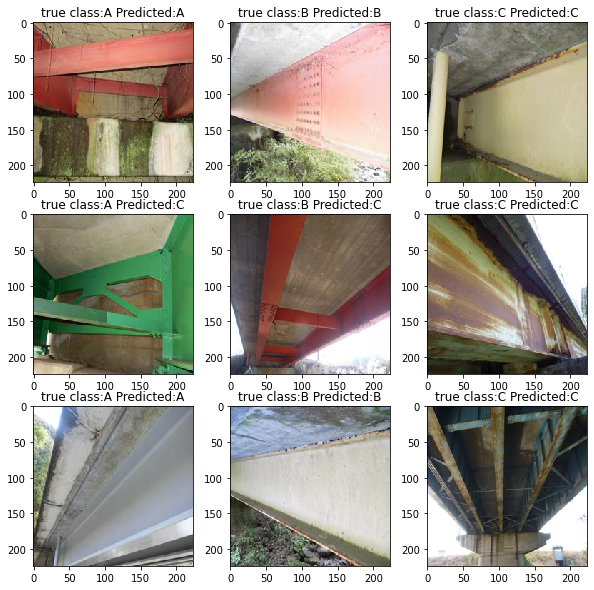

In [ ]:
testvisualization(3)

# おわりに
最後まで見ていただき、ありがとうございました。

ご意見ご不明点がございましたら、ご連絡ください。


埼玉大学　環境社会デザイン学科　党、浅本

048-858-3552

dangji@mail.saitama-u.ac.jp